<a href="https://colab.research.google.com/github/Deleon57/EDAR-REGRESSION/blob/main/RandomForrest1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [2]:
data1 = pd.read_csv("GFI_dataset.csv")

# Convert Date column to datetime
data1['Date'] = pd.to_datetime(data1['Date'])
data1 = data1.sort_values('Date')
data1.set_index('Date', inplace=True)

print(data1.head())


                  Close         High          Low         Open
Date                                                          
2012-12-31  9091.963867  9151.554951  8999.072886  9104.232763
2013-01-01  9091.963867  9091.963867  9091.963867  9091.963867
2013-01-02  9323.318359  9325.946504  9043.767691  9151.556707
2013-01-03  9335.583984  9376.772209  9183.978625  9289.138496
2013-01-04  9049.024414  9131.399905  8955.256723  9113.873744


/tmp/ipython-input-2589548011.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data1['Date'] = pd.to_datetime(data1['Date'])


In [3]:
from statsmodels.tsa.stattools import adfuller

# Loop through each feature
for col in ["Close", "High", "Low", "Open"]:
    result = adfuller(data1[col].dropna())
    print(f"Feature: {col}")
    print("  ADF Statistic:", result[0])
    print("  p-value:", result[1])
    print("-" * 40)


Feature: Close
  ADF Statistic: -0.8927524476821448
  p-value: 0.790349769845352
----------------------------------------
Feature: High
  ADF Statistic: -1.129604601213029
  p-value: 0.7031227284341343
----------------------------------------
Feature: Low
  ADF Statistic: -1.0113363349123317
  p-value: 0.7491072102344439
----------------------------------------
Feature: Open
  ADF Statistic: -1.0917706683810122
  p-value: 0.7183424850696943
----------------------------------------


In [4]:
# Define the ADF test function
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'Augmented Dickey-Fuller Test: {title}')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('-'*50)

features = data1.select_dtypes(include=[np.number]).columns

# Calculate percentage change (returns)
data_returns = data1[features].pct_change().dropna()

# Run ADF test on each feature
for col in features:
    adf_test(data_returns[col], title=f"{col} (Returns)")

Augmented Dickey-Fuller Test: Close (Returns)
ADF Statistic: -40.17952119272028
p-value: 0.0
--------------------------------------------------
Augmented Dickey-Fuller Test: High (Returns)
ADF Statistic: -39.88932325419743
p-value: 0.0
--------------------------------------------------
Augmented Dickey-Fuller Test: Low (Returns)
ADF Statistic: -13.49927808718864
p-value: 2.9990343346863835e-25
--------------------------------------------------
Augmented Dickey-Fuller Test: Open (Returns)
ADF Statistic: -18.951097277075363
p-value: 0.0
--------------------------------------------------


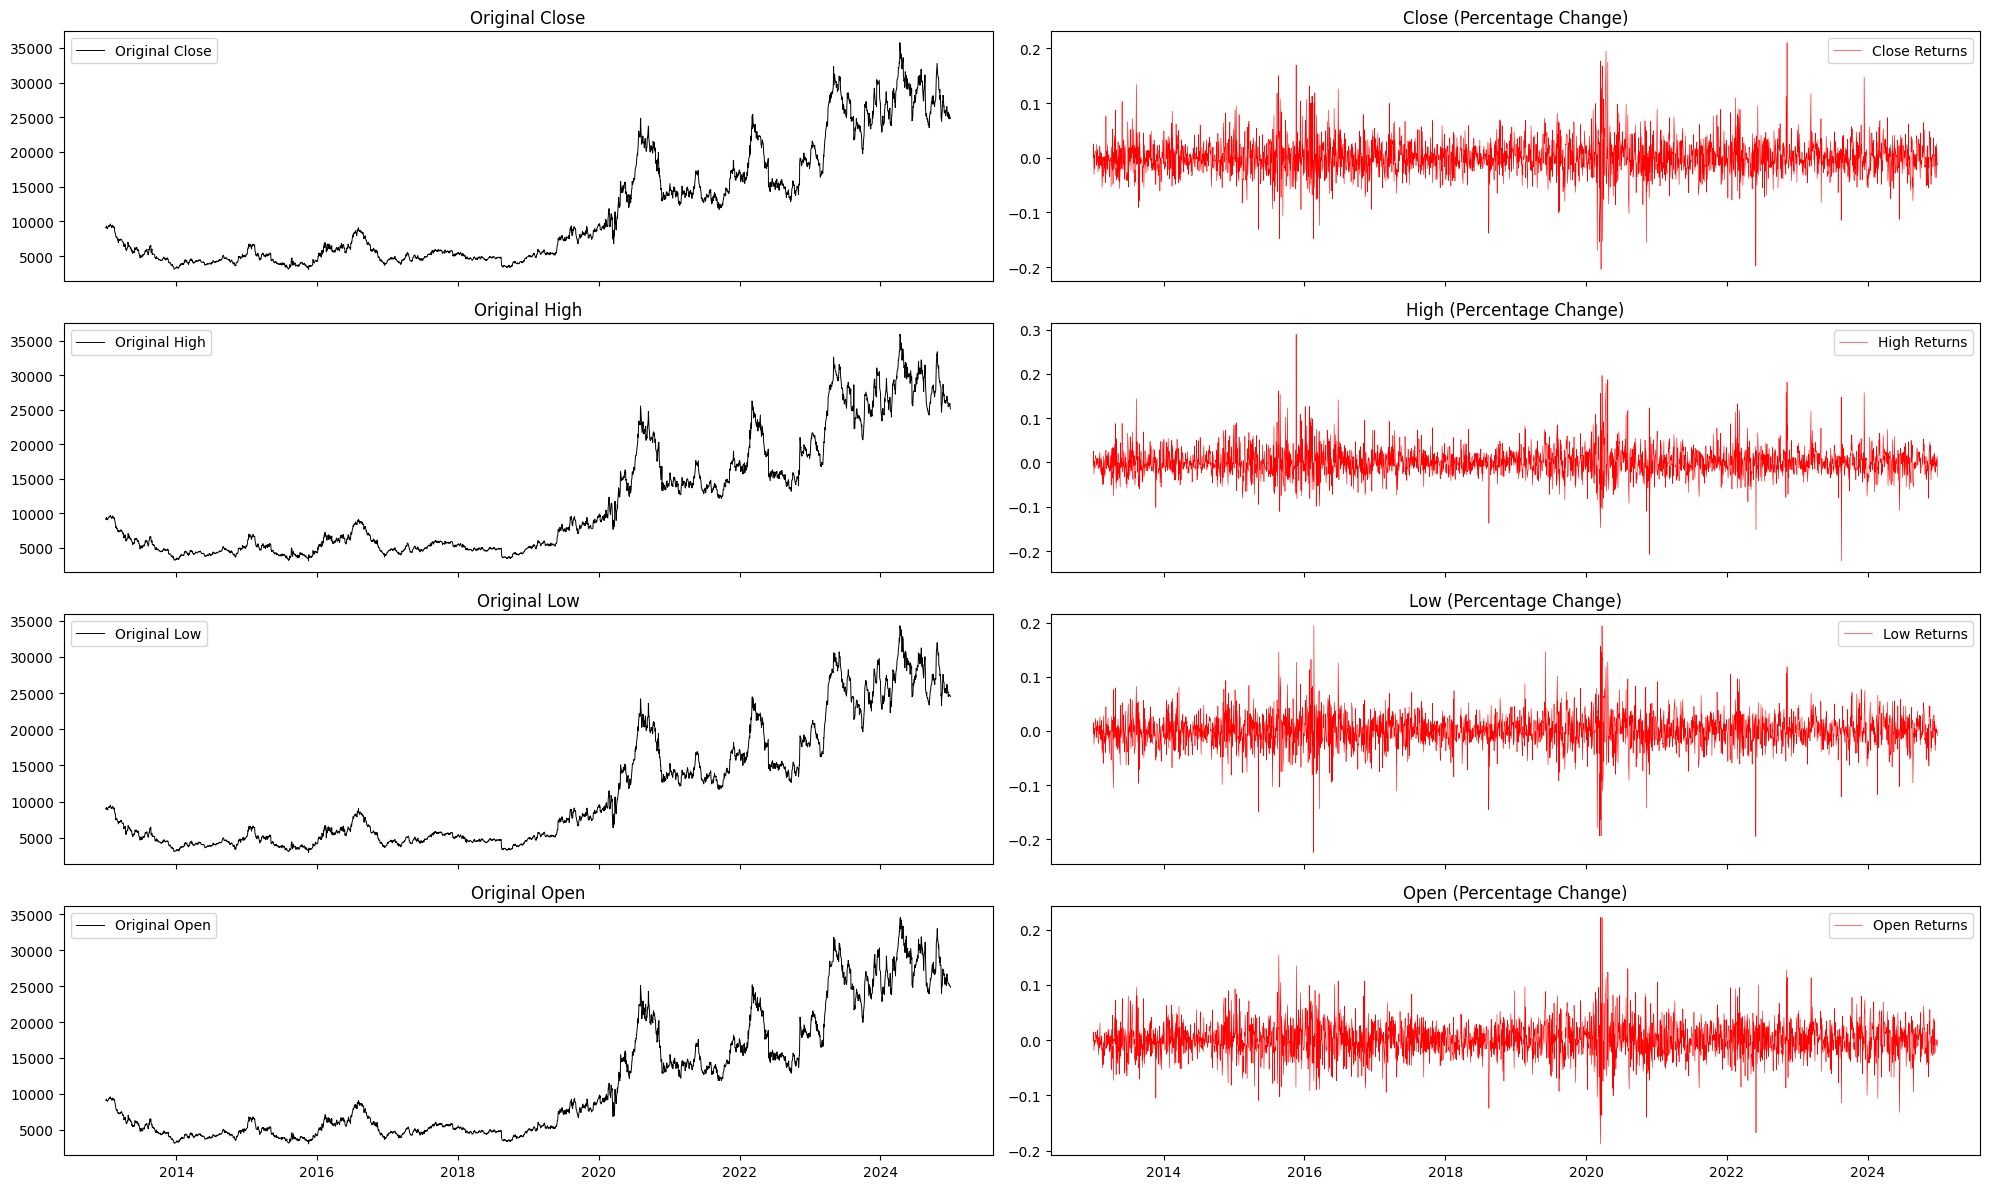

In [25]:
n_features = len(features)
fig, axes = plt.subplots(n_features, 2, figsize=(20, 3*n_features), sharex=True)

for i, col in enumerate(features):
    # Plot original in black, thin line
    axes[i, 0].plot(data1[col], label=f"Original {col}", color='black', linewidth=0.7)
    axes[i, 0].set_title(f"Original {col}")
    axes[i, 0].legend()

    # Plot returns in red, thin line
    axes[i, 1].plot(data_returns[col], label=f"{col} Returns", color='red', linewidth=0.4)
    axes[i, 1].set_title(f"{col} (Percentage Change)")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


In [ ]:
data_returns.to_csv("GFI_dataset_returns.csv", index=True)

print("✅ Stationary dataset saved as 'GFI_dataset_returns.csv'")

✅ Stationary dataset saved as 'GFI_dataset_returns.csv'


In [16]:
from sklearn.preprocessing import StandardScaler

train_RFR = data_returns[data_returns.index < "2023-01-01"]
test_RFR = data_returns[data_returns.index >= "2023-01-01"]

X_train_RFR = train_RFR[["High", "Low", "Open"]]
y_train_RFR = train_RFR["Close"]

X_test_RFR = test_RFR[["High", "Low", "Open"]]
y_test_RFR = test_RFR["Close"]

print("Before scaling (RFR):")
print("Train shape (RFR):", X_train_RFR.shape, y_train_RFR.shape)
print("Test shape (RFR):", X_test_RFR.shape, y_test_RFR.shape)

scaler_RFR = StandardScaler()

X_train_scaled_RFR = scaler_RFR.fit_transform(X_train_RFR)
X_test_scaled_RFR = scaler_RFR.transform(X_test_RFR)

print("\nAfter scaling (RFR):")
print("X_train_scaled shape (RFR):", X_train_scaled_RFR.shape)
print("X_test_scaled shape (RFR):", X_test_scaled_RFR.shape)

Before scaling (RFR):
Train shape (RFR): (2551, 3) (2551,)
Test shape (RFR): (497, 3) (497,)

After scaling (RFR):
X_train_scaled shape (RFR): (2551, 3)
X_test_scaled shape (RFR): (497, 3)


In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Fit Random Forest model (RFR) ---
rf_model_RFR = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_RFR.fit(X_train_scaled_RFR, y_train_RFR)

# --- Predictions (RFR) ---
y_pred_RFR = rf_model_RFR.predict(X_test_scaled_RFR)

# --- Metrics (RFR) ---
rmse_RFR = np.sqrt(mean_squared_error(y_test_RFR, y_pred_RFR))
mae_RFR = mean_absolute_error(y_test_RFR, y_pred_RFR)
mape_RFR = np.mean(np.abs((y_test_RFR - y_pred_RFR) / y_test_RFR)) * 100
smape_RFR = (100/len(y_test_RFR)) * np.sum(2 * np.abs(y_pred_RFR - y_test_RFR) / (np.abs(y_test_RFR) + np.abs(y_pred_RFR)))
r2_RFR = r2_score(y_test_RFR, y_pred_RFR)

# --- Put results in DataFrame ---
results_df_RFR = pd.DataFrame({
    "Model": ["RandomForest"],
    "RMSE": [rmse_RFR],
    "MAE": [mae_RFR],
    "MAPE%": [mape_RFR],
    "SMAPE%": [smape_RFR],
    "R²": [r2_RFR]
})

display(results_df_RFR)



,Model,RMSE,MAE,MAPE%,SMAPE%,R²
0,RandomForest,0.017814,0.012194,173.439139,91.439773,0.59676


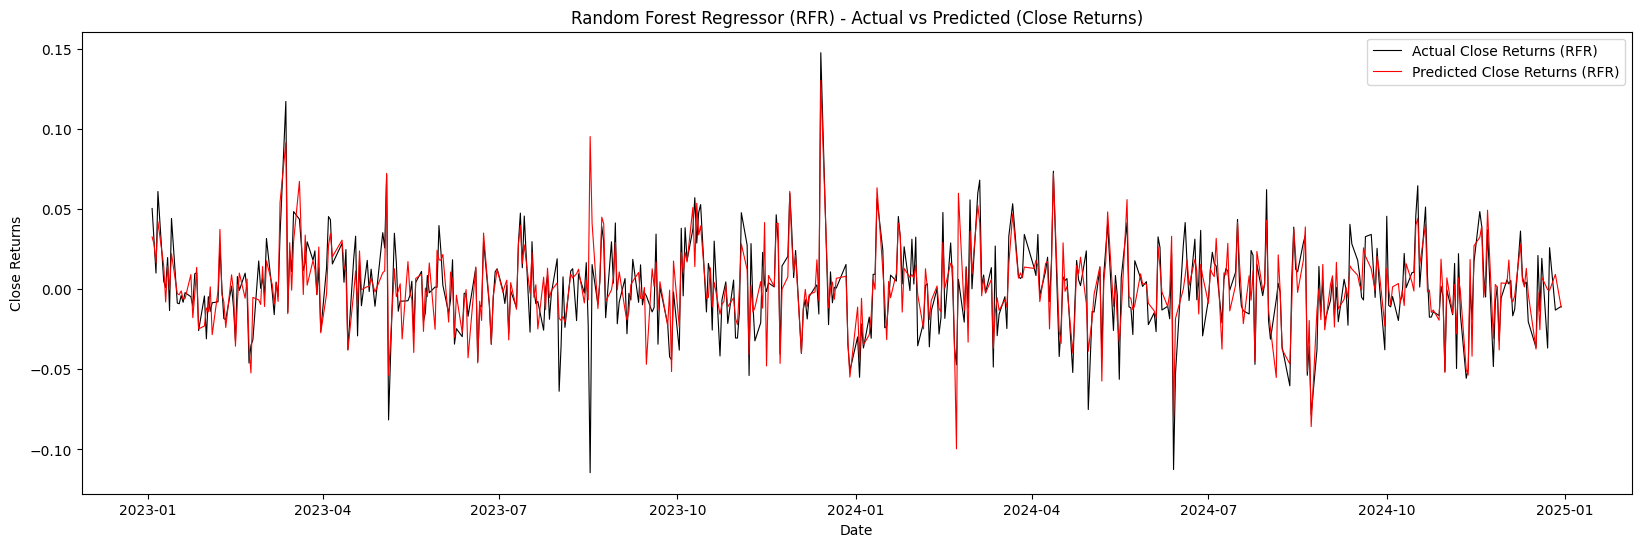

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

plt.plot(y_test_RFR.index, y_test_RFR,
         label="Actual Close Returns (RFR)",
         color="black", linewidth=0.8)

plt.plot(y_test_RFR.index, y_pred_RFR,
         label="Predicted Close Returns (RFR)",
         color="red", linewidth=0.8)

plt.title("Random Forest Regressor (RFR) - Actual vs Predicted (Close Returns)")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()



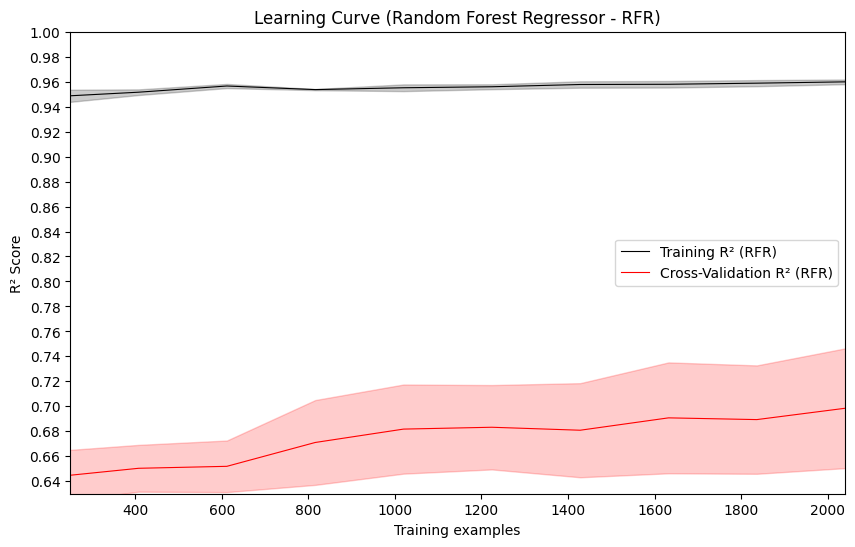

In [47]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

plt.figure(figsize=(10, 6))

# Plot learning curves
plt.plot(train_sizes_RFR, train_mean_RFR,
         label="Training R² (RFR)", color="black", linewidth=0.8)
plt.plot(train_sizes_RFR, test_mean_RFR,
         label="Cross-Validation R² (RFR)", color="red", linewidth=0.8)

# Shaded error bands
plt.fill_between(train_sizes_RFR,
                 train_mean_RFR - train_std_RFR,
                 train_mean_RFR + train_std_RFR,
                 alpha=0.2, color="black")
plt.fill_between(train_sizes_RFR,
                 test_mean_RFR - test_std_RFR,
                 test_mean_RFR + test_std_RFR,
                 alpha=0.2, color="red")

# Titles and labels
plt.title("Learning Curve (Random Forest Regressor - RFR)")
plt.xlabel("Training examples")
plt.ylabel("R² Score")
plt.legend(loc="best")

# Adjust axis scaling
plt.ylim(0.63, 1.0)
plt.xlim(250, max(train_sizes_RFR))

# ✅ Set smaller y-axis tick intervals (0.02 here)
plt.gca().yaxis.set_major_locator(MultipleLocator(0.02))

plt.show()


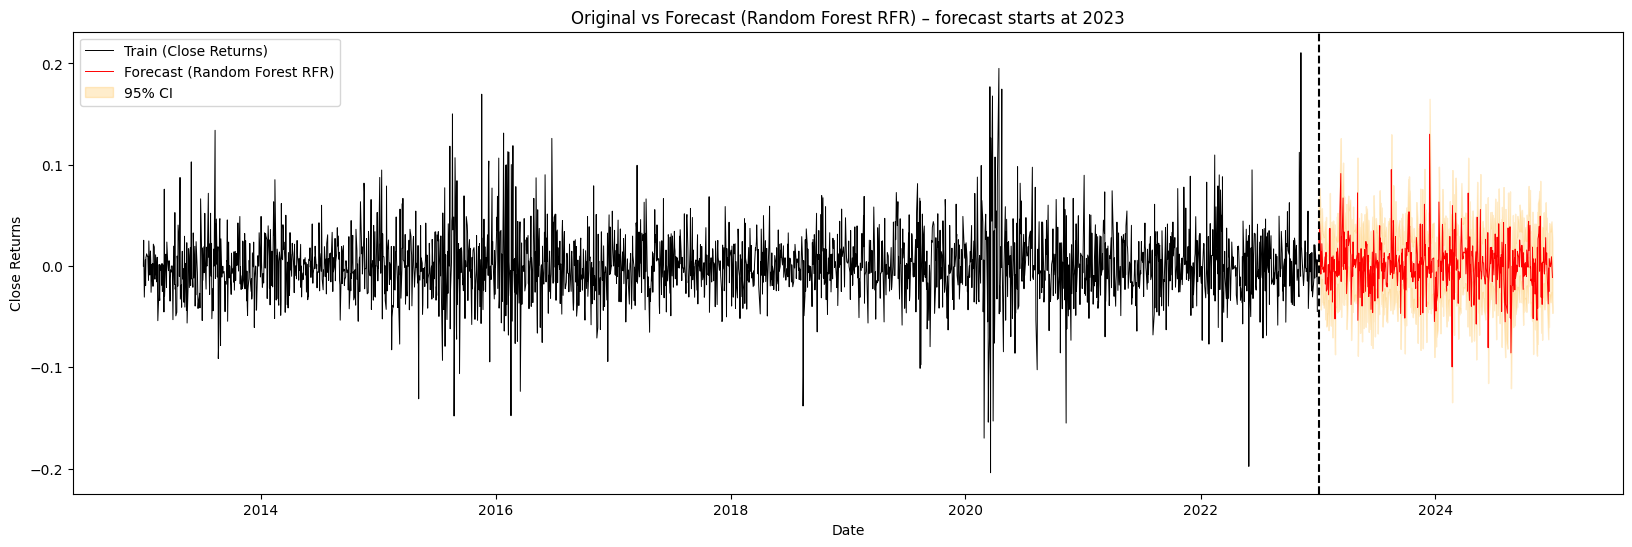

In [36]:
# Error and confidence interval
error_RFR = y_test_RFR.values - y_pred_RFR
err_std_RFR = np.std(error_RFR)
lower_RFR = y_pred_RFR - 1.96 * err_std_RFR
upper_RFR = y_pred_RFR + 1.96 * err_std_RFR

plt.figure(figsize=(20, 6))

# Training data (blue) – use actual index
plt.plot(X_train_RFR.index, y_train_RFR.values, label="Train (Close Returns)", color="black", linewidth=0.7)

# Forecast (orange) – align with test index
plt.plot(y_test_RFR.index, y_pred_RFR, label="Forecast (Random Forest RFR)", color="red", linewidth=0.7)

# Confidence Interval
plt.fill_between(y_test_RFR.index, lower_RFR, upper_RFR, color="orange", alpha=0.2, label="95% CI")

# Vertical line at boundary (start of test set)
plt.axvline(x=y_test_RFR.index[0], color="k", linestyle="--")

# Labels and legend
plt.title("Original vs Forecast (Random Forest RFR) – forecast starts at 2023")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()



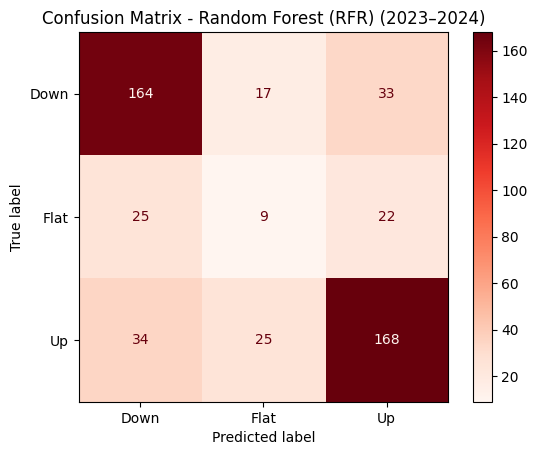

Classification Report - Random Forest (RFR)
              precision    recall  f1-score   support

        Down       0.74      0.77      0.75       214
        Flat       0.18      0.16      0.17        56
          Up       0.75      0.74      0.75       227

    accuracy                           0.69       497
   macro avg       0.56      0.56      0.56       497
weighted avg       0.68      0.69      0.68       497



In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Ensure arrays ---
y_test_arr_RFR = np.array(y_test_RFR).flatten()
y_pred_arr_RFR = np.array(y_pred_RFR).flatten()

# --- 2. Convert regression outputs into classes ---
def to_class_RFR(delta, eps=None):
    """
    Convert price changes into classes:
    +1 = Up, -1 = Down, 0 = Flat (within epsilon threshold)
    """
    if eps is None:
        eps = 0.1 * np.std(delta)  # threshold based on std deviation

    cls = np.zeros_like(delta, dtype=int)
    cls[delta > eps] = 1    # Up
    cls[delta < -eps] = -1  # Down
    return cls

# --- 3. Compute daily differences ---
delta_true_RFR = np.diff(y_test_arr_RFR, prepend=y_test_arr_RFR[0])
delta_pred_RFR = np.diff(y_pred_arr_RFR, prepend=y_pred_arr_RFR[0])

# --- 4. Convert differences to classes ---
true_cls_RFR = to_class_RFR(delta_true_RFR)
pred_cls_RFR = to_class_RFR(delta_pred_RFR)

# --- 5. Confusion Matrix ---
labels_RFR = [-1, 0, 1]  # Down, Flat, Up
cm_RFR = confusion_matrix(true_cls_RFR, pred_cls_RFR, labels=labels_RFR)

disp_RFR = ConfusionMatrixDisplay(confusion_matrix=cm_RFR, display_labels=["Down", "Flat", "Up"])
disp_RFR.plot(cmap="Reds", values_format="d")
plt.title("Confusion Matrix - Random Forest (RFR) (2023–2024)")
plt.show()

# --- 6. Classification Report ---
print("Classification Report - Random Forest (RFR)")
print(classification_report(true_cls_RFR, pred_cls_RFR, target_names=["Down", "Flat", "Up"]))



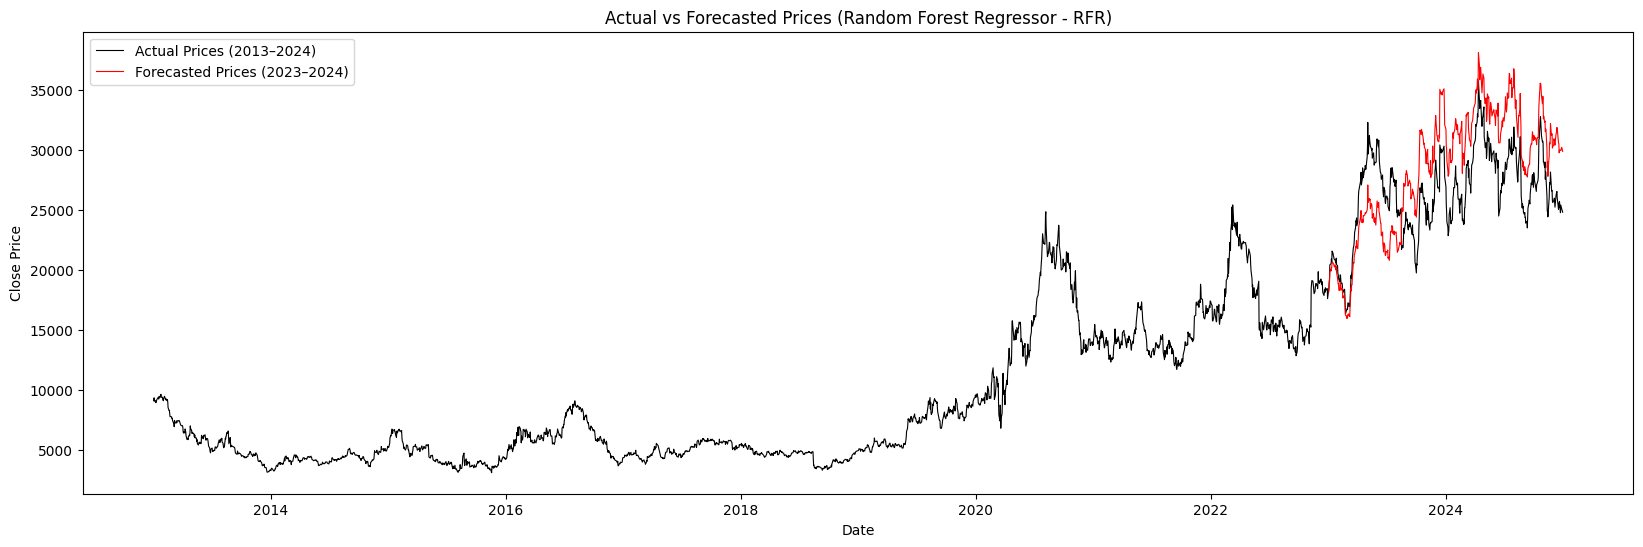

In [38]:
P0_RFR = data1["Close"].iloc[0]  # first actual price in 2013
reconstructed_prices_RFR = (1 + data_returns["Close"]).cumprod() * P0_RFR

last_price_2022_RFR = data1.loc[data1.index < "2023-01-01", "Close"].iloc[-1]  # last actual before 2023

forecast_prices_RFR = (1 + pd.Series(y_pred_RFR, index=y_test_RFR.index)).cumprod() * last_price_2022_RFR

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

# Actual reconstructed prices (black, thin line)
plt.plot(reconstructed_prices_RFR.index, reconstructed_prices_RFR,
         label="Actual Prices (2013–2024)", color="black", linewidth=0.8)

# Forecasted prices (red, thin line)
plt.plot(forecast_prices_RFR.index, forecast_prices_RFR,
         label="Forecasted Prices (2023–2024)", color="red", linewidth=0.8)

plt.title("Actual vs Forecasted Prices (Random Forest Regressor - RFR)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()




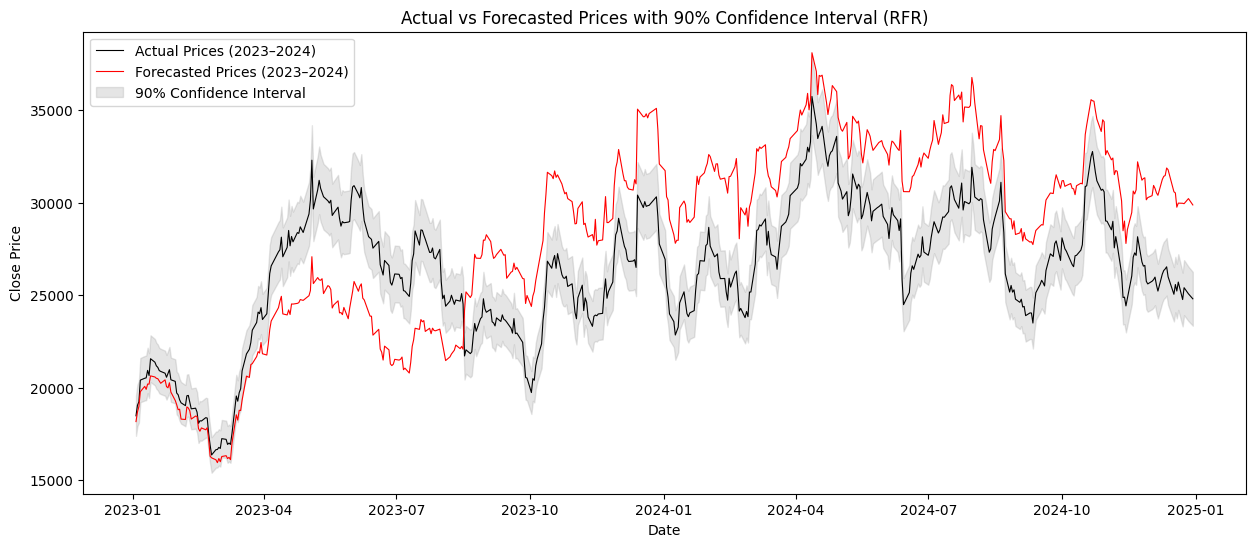

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# --- Residuals from test set ---
residuals_RFR = y_test_RFR - y_pred_RFR
std_resid_RFR = np.std(residuals_RFR)

# 90% z-score
z_90 = 1.645

# Restrict actuals to forecast period
actual_trimmed = reconstructed_prices_RFR.loc[forecast_prices_RFR.index]

# Scale confidence interval as a percentage of actual prices
ci_band = z_90 * std_resid_RFR * actual_trimmed * 2   # adjust 0.05 if needed for visibility

upper_bound = actual_trimmed + ci_band
lower_bound = actual_trimmed - ci_band

plt.figure(figsize=(15, 6))

# Actual reconstructed prices
plt.plot(actual_trimmed.index, actual_trimmed,
         label="Actual Prices (2023–2024)", color="black", linewidth=0.8)

# Forecasted prices
plt.plot(forecast_prices_RFR.index, forecast_prices_RFR,
         label="Forecasted Prices (2023–2024)", color="red", linewidth=0.8)

# Confidence interval shading (same style as learning curve)
plt.fill_between(actual_trimmed.index,
                 lower_bound, upper_bound,
                 color="grey", alpha=0.2, label="90% Confidence Interval")

plt.title("Actual vs Forecasted Prices with 90% Confidence Interval (RFR)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()
